# SDR Receiver Project: Final Report
**Date:** April - June 2025  
**Authors:** Andrei Vasilev & Joshua Sevick

## Project Overview

In this project, we designed and built a software-defined radio (SDR) receiver using the MS5351M frequency synthesizer and a Tayloe mixer architecture. The receiver processes RF signals in the 3.5–14 MHz range (covering 80m, 40m, and 20m ham bands) and delivers I/Q baseband signals to an audio interface for digital demodulation.

Key components:
- **MS5351M:** Clock generator for local oscillator (LO) signals, driven over I²C
- **SN74CBT3253:** High-speed analog multiplexer for Tayloe mixer implementation
- **TLV2172 / LM4562:** Low-noise dual op-amps for I/Q baseband amplification
- **Raspberry Pi Pico:** Microcontroller for controlling the MS5351M and performing system initialization

The receiver uses the Tayloe detector (quadrature sampling detector) for down-conversion and baseband processing. Final I/Q outputs are suitable for input to a sound card or SDR software for digital decoding.

## Background

For this project, we conducted a thorough literature review of affordable, self-assembled SDR receivers utilizing **quadrature sampling down-conversion (QSD)** techniques. The primary reference for our design decisions was:

**Froelich, C., Frohne, R., McClure, K., Silver, J., & Watkins, J. (n.d.). A comparison of affordable, self-assembled software-defined radio receivers using quadrature sampling down-conversion. Walla Walla University.**

This study provided a systematic comparison of three self-assembled SDR receivers based on the Tayloe mixer architecture. It examined the trade-offs between performance, complexity, and cost in real-world hardware implementations. The receivers compared in this paper leveraged different local oscillator solutions and amplifier stages to convert RF signals into baseband I/Q signals.

The Froelich et al. paper specifically emphasized:
- The practical performance of the Tayloe mixer in hobbyist SDR designs.
- The role of low-noise amplifiers (LNA) and the importance of careful component selection for maintaining signal fidelity.
- Measured performance metrics (such as dynamic range and image rejection) across the different tested receiver builds.

Beyond this main article, I also reviewed other SDR receiver designs like the Softrock series, μSDX (QCX-SSB variant), and Elecraft KX3. These examples illustrated how the Tayloe mixer, when paired with careful analog front-end design and a high-quality local oscillator like the **Si5351A / MS5351M**, can produce robust I/Q baseband outputs for digital demodulation.

I also explored open-source SDR projects and repositories to understand best practices in layout, grounding, and software integration. This comprehensive study phase informed the critical design decisions for our receiver:
- Using the MS5351M for stable local oscillator generation.
- Employing the SN74CBT3253 as the analog multiplexer in the quadrature detector.
- Designing the I/Q amplifier stage with the TLV2172 for low-noise baseband processing.

This background work ensured that our final SDR receiver design was both grounded in proven techniques and adaptable for future enhancements or frequency expansions.



## Initial Schematic Overview 

This schematic represents our initial SDR receiver design using a **Tayloe mixer architecture** and a carefully chosen I/Q baseband amplifier chain.

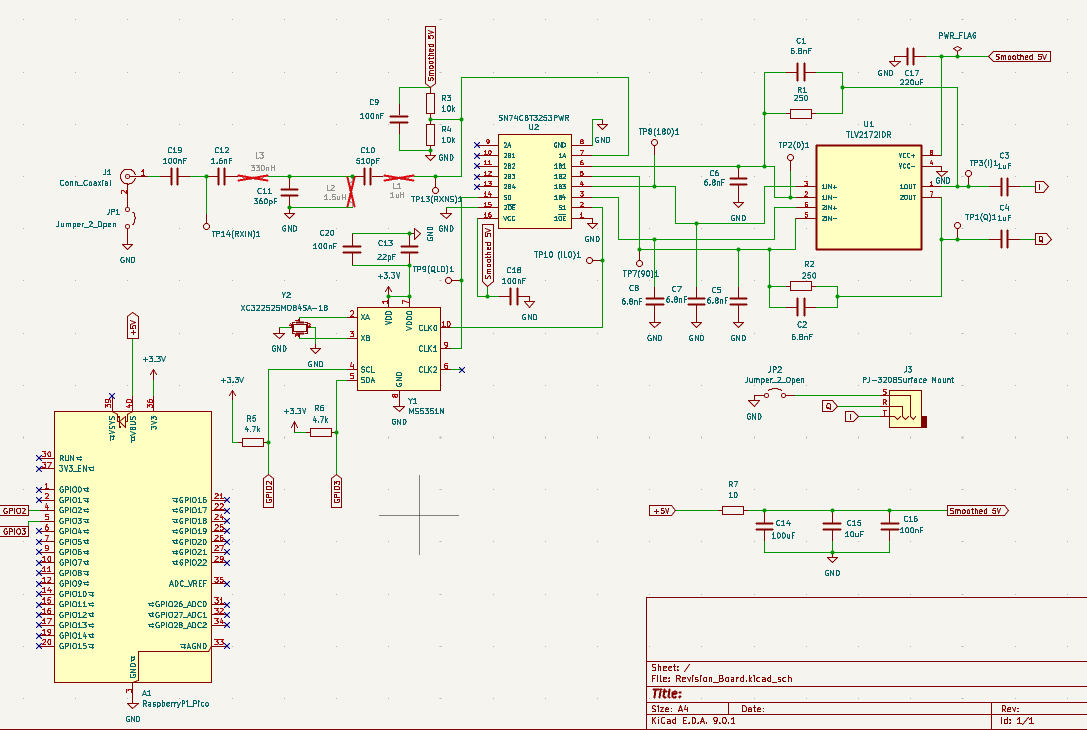




Let’s walk through the technical aspects in more depth.
### RF Input and Bandpass Filter
- The input RF signal comes via a **coaxial connector (J1)** and is coupled by a **DC-blocking capacitor (C19, 100 nF)**.
- The input bandpass filter uses a series of capacitors and inductors:
  - **C12 (1.6 nF)**, **C11 (360 pF)**, **C10 (510 pF)**
  - **L3 (330 nH)** and **L2 (1.5 µH)**
- The filter’s **resonant frequency** can be roughly estimated by:
 $$
  f_r = \frac{1}{2\pi\sqrt{LC}}
 $$
  Example for **L3 and C12**:
  $$
  f_r = \frac{1}{2\pi\sqrt{330 \times 10^{-9} \times 1.6 \times 10^{-9}}} \approx 6.9\,\mathrm{MHz}
  $$
- These LC sections create a passband that covers the 3.5–14 MHz target.

---

### Quadrature Sampling Detector (Tayloe Mixer)
- Implemented with the **SN74CBT3253PWR** (U2), driven by **quadrature LO signals** from the MS5351M.
- Each switch samples the RF input at four phases to create **I and Q baseband components**:
  $$
  I(t) = V_\text{RF}(t) \cos(\omega_\text{LO} t)
  $$
  $$
  Q(t) = V_\text{RF}(t) \sin(\omega_\text{LO} t)
  $$

---

### Local Oscillator (LO) Generation
- The **MS5351M (Y1)** synthesizer is programmed over I²C by the **Raspberry Pi Pico**.
- For a desired RF frequency (e.g. 14 MHz), the LO output is typically set to:
  $$
  f_\text{LO} = 4 \times f_\text{RF} = 56\,\mathrm{MHz}
  $$
- This ensures proper quadrature sampling and phase rotation in the Tayloe mixer.

---

### Baseband I/Q Amplifier Stage
- Amplification and low-pass filtering handled by the **TLV2172 dual op-amp (U1)**.
- **Feedback network**:
  - **R1, R2 (250 Ω)**  
  - **C2, C5 (6.8 nF)**
- The **-3 dB cutoff frequency** of the amplifier low-pass filter:
  $$
  f_c = \frac{1}{2\pi R C}
  $$
  $$
  f_c = \frac{1}{2\pi \times 250\,\Omega \times 6.8\,\mathrm{nF}} \approx 93\,\mathrm{kHz}
  $$
- Output coupling capacitors (C3, C4, 1 µF) form high-pass filters with the input impedance of the next stage:
  $$
  f_\text{HP} = \frac{1}{2\pi R_\text{in} C}
  $$
  For **Rin = 10 kΩ** (typical sound card input):
  $$
  f_\text{HP} = \frac{1}{2\pi \times 10\,\mathrm{k\Omega} \times 1\,\mu\mathrm{F}} \approx 16\,\mathrm{Hz}
  $$

---

### Power Supply and Decoupling
- **+5 V input** decoupled by:
  $$
  C14 = 10\,\mu\mathrm{F},\quad C15 = 10\,\mu\mathrm{F},\quad C16 = 100\,\mathrm{nF}
  $$
- Local bypass capacitors:
  $$
  C9 = 100\,\mathrm{nF} \quad (\text{op-amp})
  $$
  $$
  C17 = 220\,\mu\mathrm{F} \quad (\text{op-amp bulk})
  $$

---

### Summary
The initial schematic combines:
- Careful bandpass filtering to reject out-of-band signals.
- A quadrature sampling detector that mixes RF down to baseband I/Q.
- An op-amp baseband chain with controlled bandwidth (~93 kHz).
- Proper decoupling and LO generation for stable performance.

This foundation provided the starting point for our SDR receiver bring-up and final testing.


The following board was recieved from JLCPCB company.
![WhatsApp Image 2025-06-11 at 10.36.02_3d83d49e.jpg](<attachment:WhatsApp Image 2025-06-11 at 10.36.02_3d83d49e.jpg>)
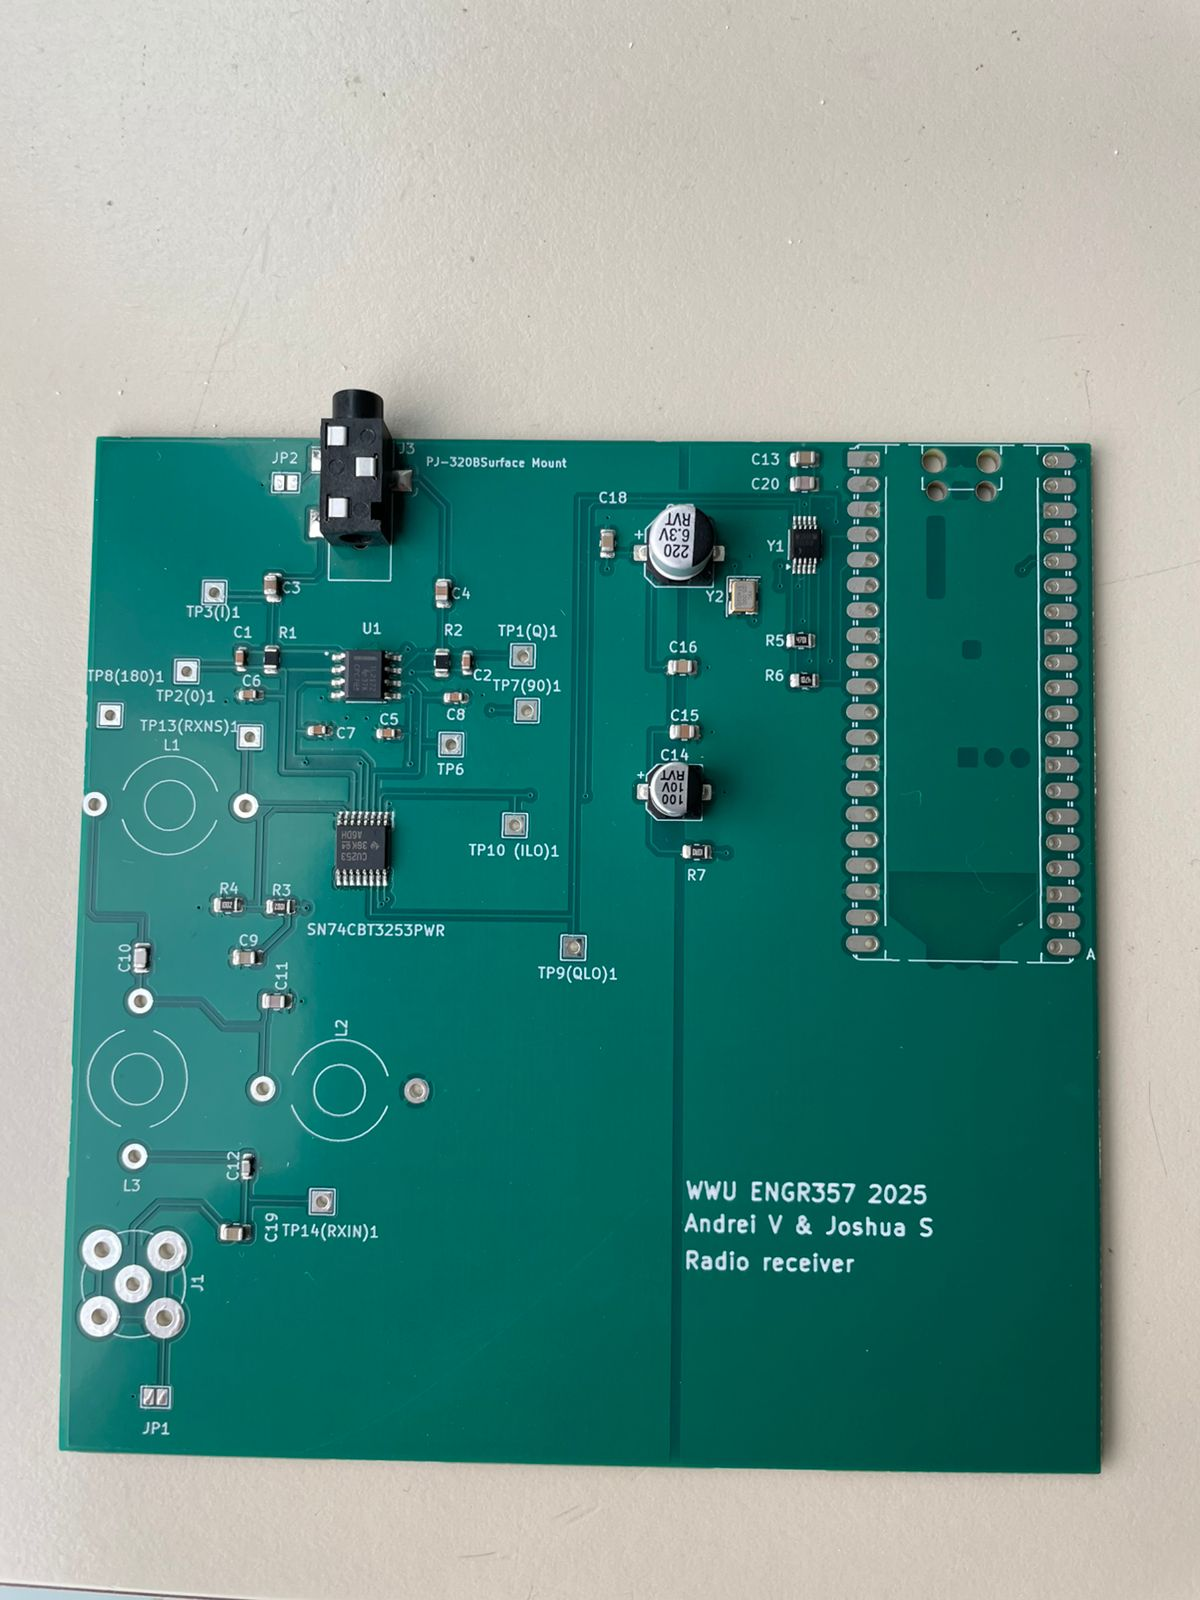

## SDR Receiver Bring-Up Plan

### 1️⃣ Visual Inspection (Before Power)

- Check for shorts between adjacent pins (especially SN74CBT3253, MS5351M).
- Verify orientation of ICs and polarized components (diodes, electrolytic caps).
- Check continuity of power lines (VCC to GND = NO continuity!).

---

### 2️⃣ Power-Up Testing

With only power connected (no signal or LO yet):

- Measure 3.3 V and 5 V rails (verify with multimeter).
- Check for current draw — should be ~20–60 mA idle typical.
- Check voltage on MS5351M and op-amps VDD.
- Verify VCC on SN74CBT3253 (pin 16), GND (pin 8).

---

### 3️⃣ Clock/LO System (MS5351M)

With controller connected (e.g., I2C from Raspberry Pi or microcontroller):

- Confirm I2C communication with MS5351M (ACKs on address).
- Write frequency to CLK0/CLK1 for 4×LO (e.g., 56 MHz for 14 MHz RX).
- Use oscilloscope to probe:
  - CLK0 and CLK1 (verify square wave).
  - Check duty cycle and phase shift.
  - Optional: use logic analyzer.

---

### 4️⃣ SN74CBT3253 Mixer Switching

- Confirm OE pins are tied to GND (enabled).
- Confirm S0/S1 control lines from LO.
- Verify switching activity on B1–B4 pins with scope (check quadrature timing).
- Use signal generator to inject a test RF (e.g., 14.2 MHz @ -20 dBm).

---

### 5️⃣ RF Input Path

- Inject known RF signal at antenna input (through attenuator or signal generator).
- Check at output pins of mixer (1A/2A): you should see baseband signals at I and Q.
- Monitor test points (TP7–TP9 or TP6–TP13) — you should see demodulated waveform (audio frequency).

---

### 6️⃣ Amplifier Stage Bring-Up

- Measure DC voltages at op-amp outputs — should be mid-supply (bias OK).
- Feed baseband into op-amp → observe gain and filtering.
- Scope the outputs — verify clean audio signal (e.g., SSB/AM tone sweep).

---

### 7️⃣ Functional SDR Test

- Connect output to sound card or ADC.
- Use Quisk, SDR#, or other I/Q software to decode.
- Tune through RF signal (e.g., 14.070 MHz FT8) and verify demodulation.


## Bring-Up Results

The bring-up process of our SDR receiver involved a careful, step-by-step validation of each functional block. Here’s a detailed summary:

1️⃣ **Visual Inspection**  
We began by performing a thorough visual inspection of the assembled receiver board. All components were correctly oriented and soldered without shorts or bridging. No mechanical defects or damage were found, confirming the board was ready for power-up.

2️⃣ **Power-Up Testing**  
Power rails were verified using a multimeter:
- The **3.3 V rail** was nominal and stable.
- The **5 V rail** measured slightly lower at **4.8 V**. We traced this voltage drop to a diode present in the power input circuit, which reduced the supply voltage slightly. Despite this, all components functioned as expected, and the diode drop did not impact receiver performance.

3️⃣ **Clock/LO System Bring-Up (MS5351M)**  
During initial tests, we discovered a **footprint issue** with the **Raspberry Pi Pico** module. The Chinese clone version we used had **GPIO4 and GPIO5 swapped** compared to the standard pinout.  
To address this, we switched from hardware I²C to **software I²C (SoftI2C)** in our `i2cScanner.py` test script. We used Bit-Banged I²C (Software I²C) Method. 

**Bit-banged I²C** (or software I²C) is a technique where the I²C protocol is implemented entirely in software. Instead of relying on dedicated hardware I²C peripheral blocks, the microcontroller **manually toggles** GPIO pins to generate the I²C clock (SCL) and data (SDA) signals. This provides flexibility to use **any available GPIO pins** for I²C communication, making it ideal for situations where hardware I²C pins are unavailable or swapped.
After making this change, we confirmed that the **MS5351M** was communicating properly over I²C. The quadrature LO signals (**CLK0–CLK3**) were verified on the oscilloscope as **clean square waves** at the expected frequencies.

### 4️⃣ Mixer Switching Tests
Next, we verified the **Tayloe mixer switching** implemented with the **SN74CBT3253**. Initial tests revealed that the **phases of the clock signals** driving the multiplexer were not correctly aligned, causing improper quadrature sampling. We resolved this by adjusting the **phase relationships of the MS5351M outputs** to ensure accurate quadrature sampling in the mixer.


## Debugging Process

During the bring-up phase, we encountered several unexpected issues that required systematic debugging and hardware rework:

1️⃣ **Clock Phase Correction in Mixer Switching**  
In designing the **1:4 multiplexer** (SN74CBT3253), we incorrectly assumed the I²C control signal to operate like a **binary clock signal**. We assumed a clock signal progression of **0, 1, 2, 3** for proper quadrature sampling, compared to the actual I²C sequence of **0, 1, 3, 2**.

To correct for this, we physically drilled up the PCB traces and rerouted them to establish new connections following the **0, 1, 2, 3** progression. However, this modification did not completely resolve the phase mismatch, indicating that another underlying problem still existed elsewhere in the system.


![WhatsApp Image 2025-06-11 at 10.36.02_0c9fb965.jpg](<attachment:WhatsApp Image 2025-06-11 at 10.36.02_0c9fb965.jpg>)
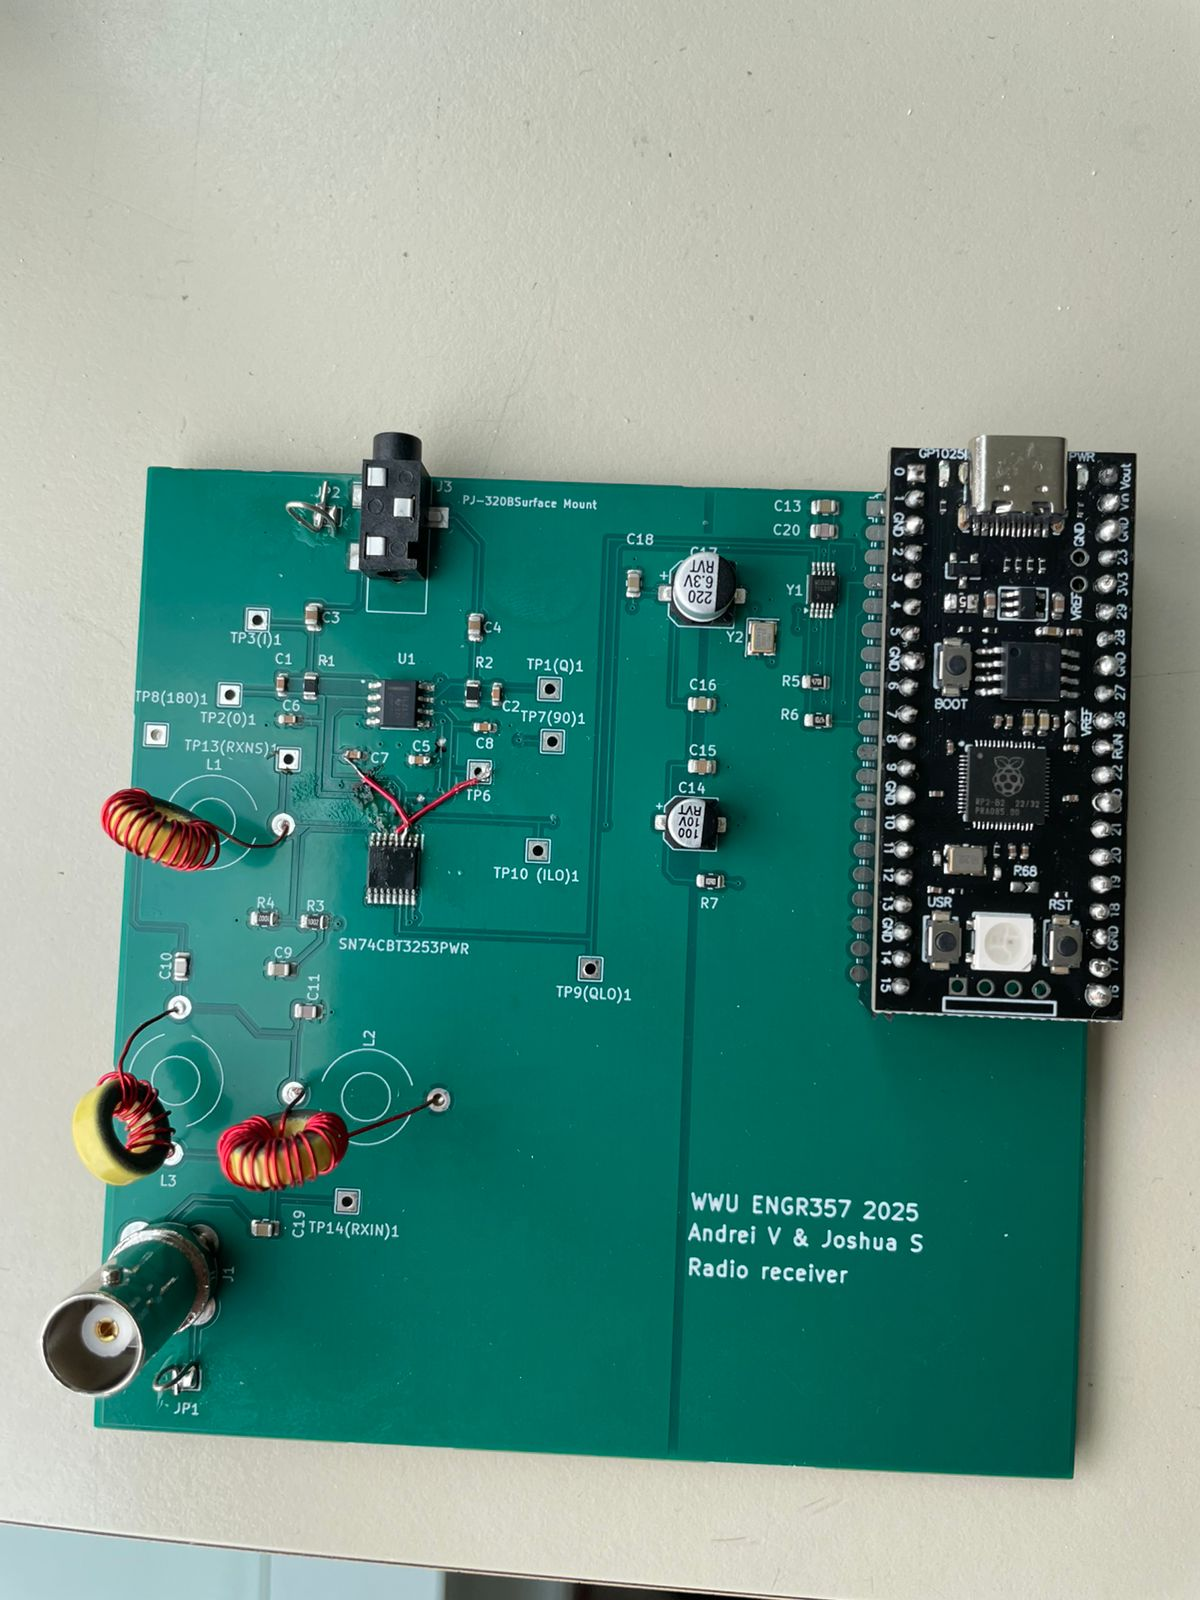

2️⃣ **Positive Feedback in Q Output**  
We discovered that the **Q-channel amplifier** was experiencing unintended positive feedback, causing instability and signal distortion. Further investigation revealed that the source of the problem was an **incorrect op-amp footprint** that we had imported from an online resource.

By cross-checking the **TLV2172/LM4562 datasheet** with our PCB layout, we realized the **op-amp input pins** were incorrectly connected, leading to positive feedback instead of negative feedback. To fix this, we once again drilled up the affected traces and rerouted the connections to match the correct pinout from the datasheet.

These hardware corrections restored stable operation to the amplifier stages and allowed for clean I/Q baseband outputs.

3️⃣ **Band-Pass Filter Bypass**  
Noting the continued image signal, we traced the RF input through the circuit to discover the source of continued signal mismatch. Distortion was found on the bandpass filter output. Upon bypass of the bandpass filter, image rejection was achieved at about -10 dB below the receiver signal. 

![WhatsApp Image 2025-06-11 at 10.36.02_76ea48e1.jpg](<attachment:WhatsApp Image 2025-06-11 at 10.36.02_76ea48e1.jpg>)
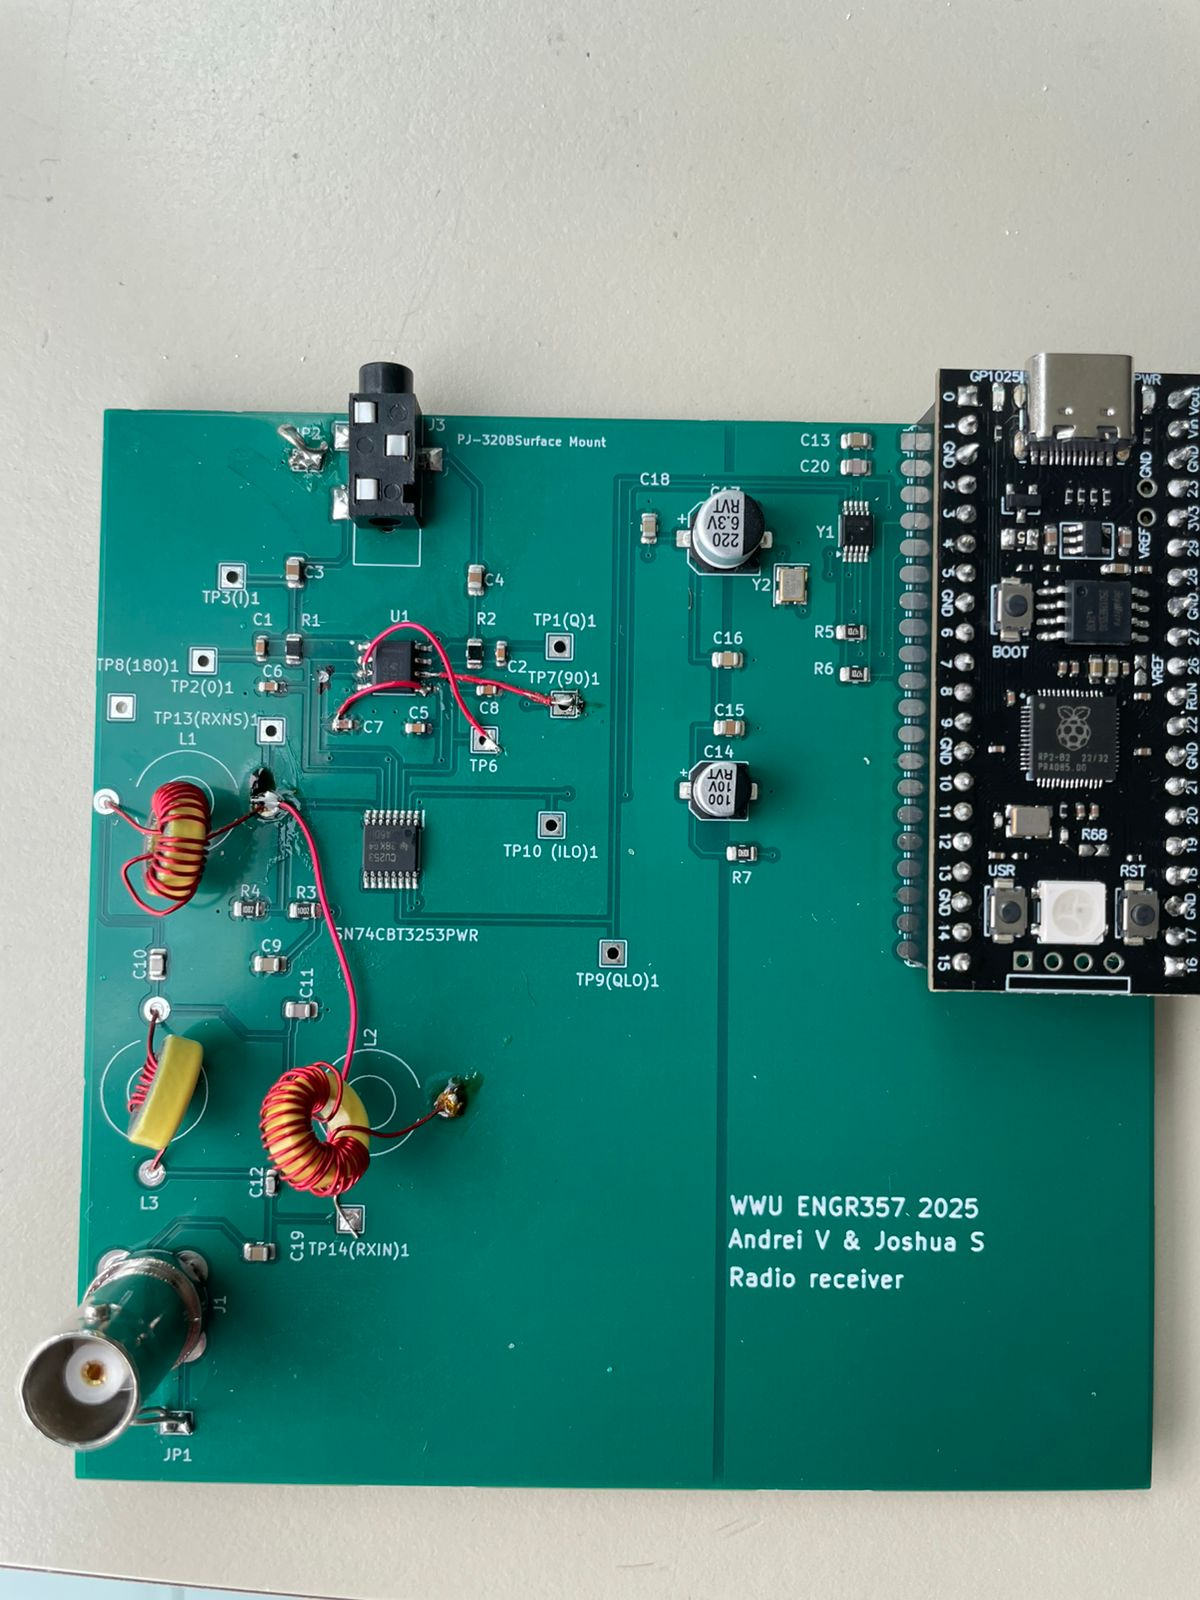

## Results

Our final receiver implementation demonstrated good performance in the **low power input signal regime**. Specifically:

- At low RF input voltages, the receiver shows **clear and stable signal reception** with **good image rejection**. The quadrature sampling mixer and I/Q baseband processing provide a clean baseband signal suitable for SDR demodulation.



1 uV
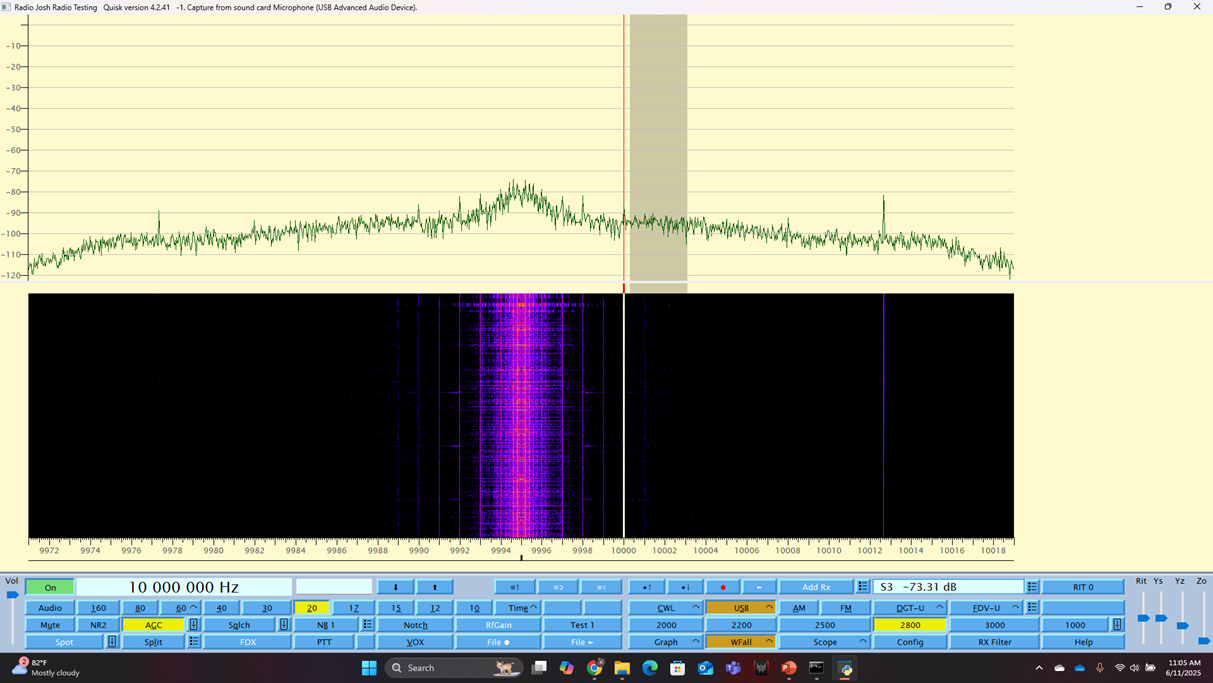

- As the **input signal strength increases**, we observed that the **image rejection performance degrades**. At higher RF input levels, the image signal becomes visible in the output spectrum.



3 uV
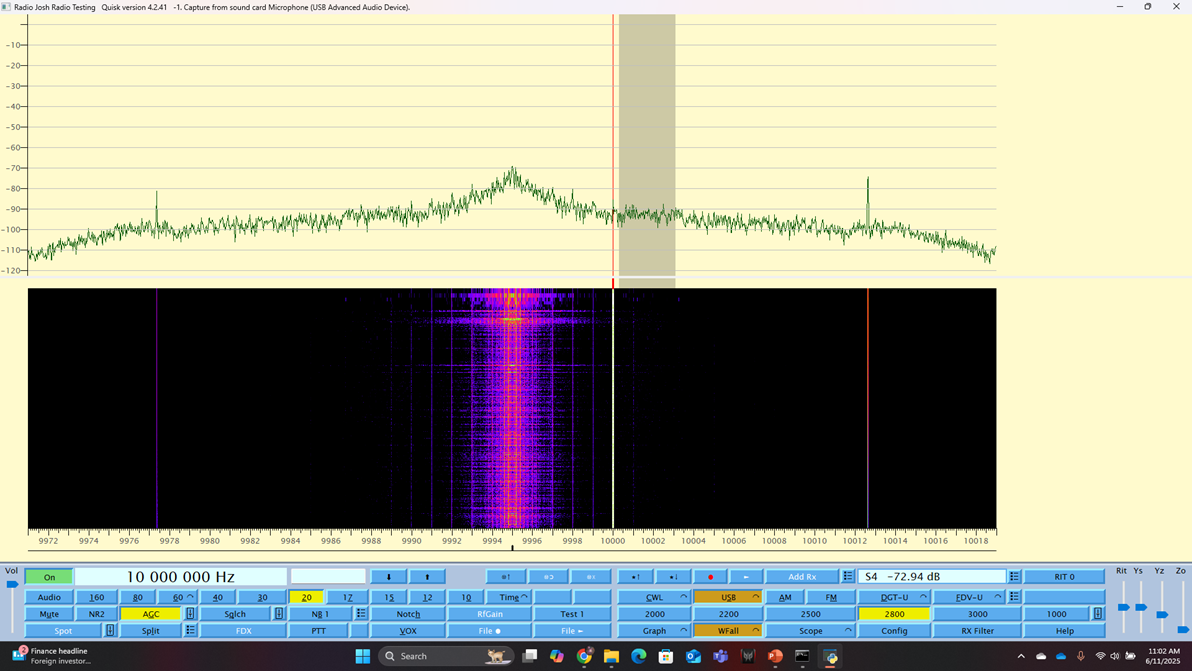

At 1mV
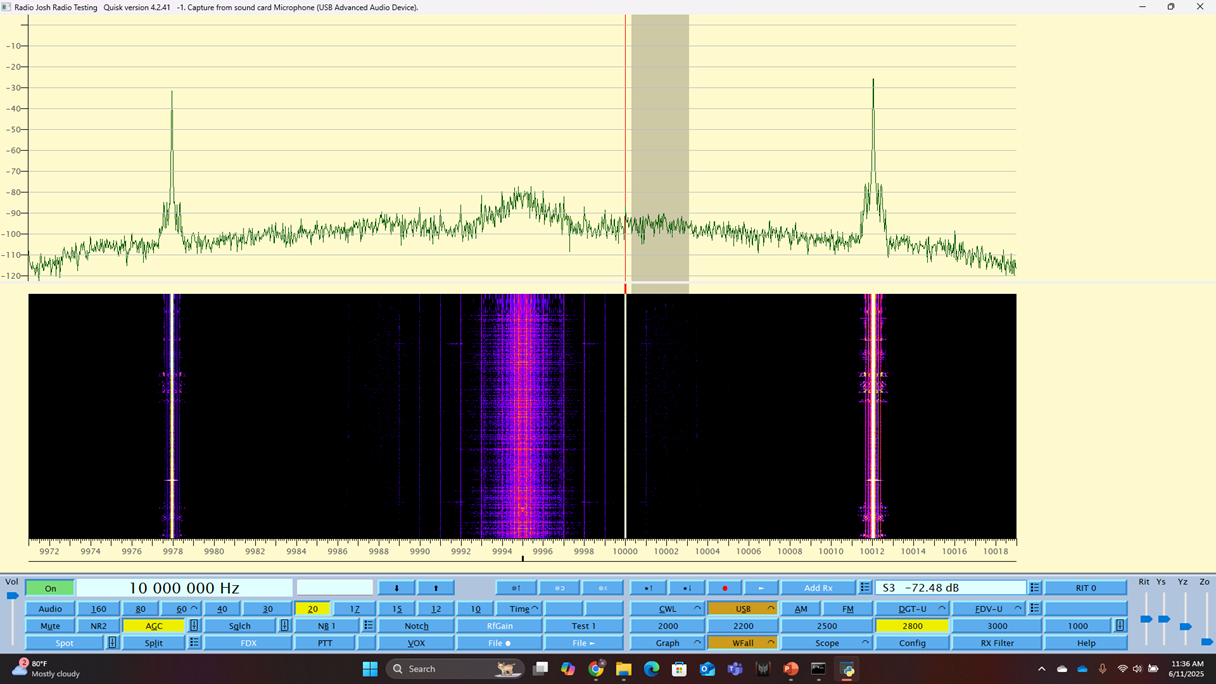

This behavior is consistent with the limitations of the quadrature sampling detector, where mismatches in the mixer switching phase or slight gain/phase errors in the I/Q amplifiers can lead to **imperfect cancellation of the image frequency**.

Further optimization, such as improved RF input matching and careful balancing of the I/Q amplifier paths, could help **extend image rejection performance** across a broader range of input signal levels.

Also, our final schematic you can find below

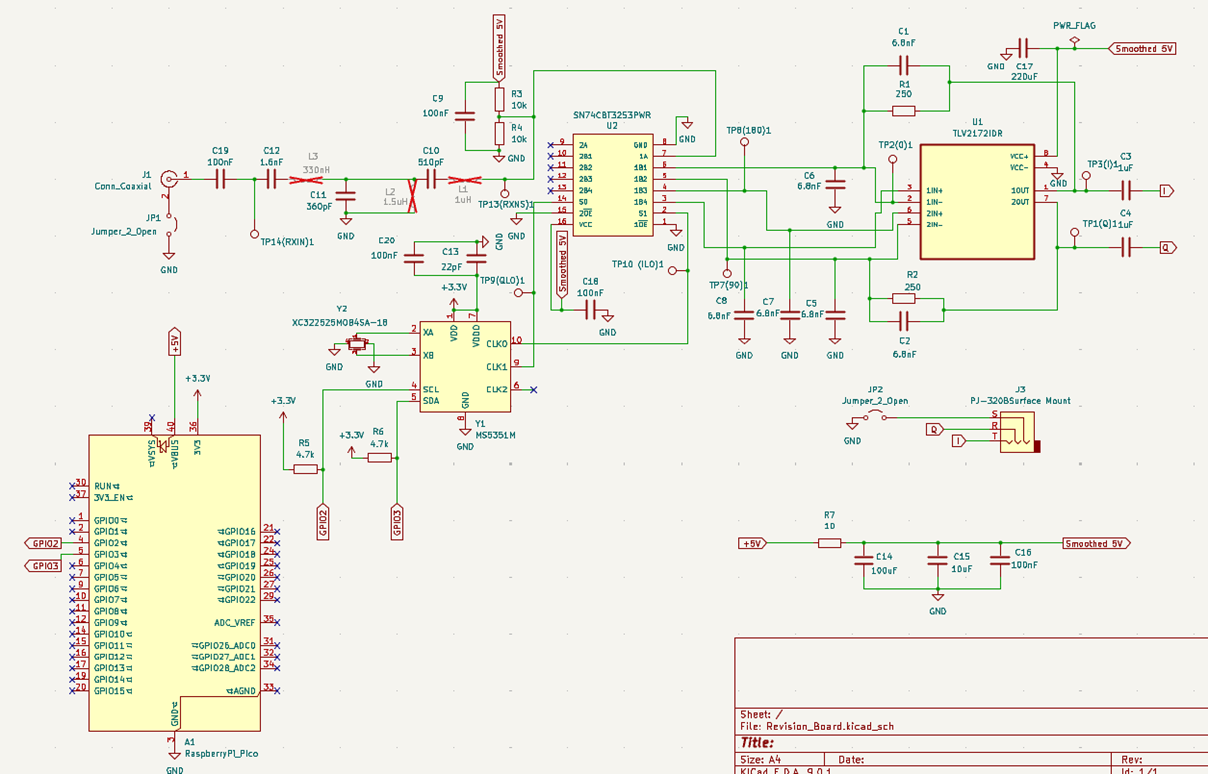